In [67]:
pip install optuna

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor

In [69]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# **Data Preprocessing and Exploratory Data Analysis**

In [70]:
# Task 1: Understanding the Dataset:

print("Dataset Overview: \n")
print(train.info())

print("\n\nSummarizing unique values in each column.: \n")
for col in train.columns:
  print(f"{col}: {train[col].nunique()}")

numerical_Cols=['Buildup_area', 'Carpet_area', 'Bathrooms', 'Property_age', 'Parking', 'Price', 'Brokerage', 'Floor', 'Per_sqft_price', 'BHK', 'Total_bedrooms']
print("\n\nDetailed statistical analysis on the numerical columns: \n")
print(train[numerical_Cols].describe(percentiles=[0.25, 0.5, 0.75]))


Dataset Overview: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6256 non-null   int64  
 1   Address         6256 non-null   object 
 2   Possesion       6256 non-null   object 
 3   Furnishing      6256 non-null   object 
 4   Buildup_area    6256 non-null   float64
 5   Carpet_area     6256 non-null   float64
 6   Bathrooms       6256 non-null   float64
 7   Property_age    6256 non-null   int64  
 8   Parking         6256 non-null   int64  
 9   Price           6256 non-null   int64  
 10  Brokerage       6256 non-null   float64
 11  Floor           6256 non-null   float64
 12  Per_sqft_price  6256 non-null   float64
 13  BHK             6256 non-null   float64
 14  Total_bedrooms  6256 non-null   float64
dtypes: float64(8), int64(4), object(3)
memory usage: 733.2+ KB
None


Summarizing unique values in each col

In [71]:
# Task 2: Drop Irrelevant Columns:

numerical_Cols=['Buildup_area', 'Carpet_area', 'Bathrooms', 'Property_age', 'Parking', 'Price', 'Brokerage', 'Floor', 'Per_sqft_price', 'BHK', 'Total_bedrooms']
print("\n\nDetailed statistical analysis on the numerical columns: \n")

corr=train[numerical_Cols].corr()

print(corr['Price'].sort_values(ascending=False))

weak_Cols=corr[(abs(corr['Price']) <= 0.1)].index.tolist() # Property_age: 0.069613

print("\nColumns with weak correlations (absolute value < 0.1):")
print(weak_Cols)

nonpredictive_Cols=['Address', 'Possesion', 'index']
# Address: It' not numerical & does't add any meaningful prediction to Prices
# index: By default, it does't help or affect Prices in any way.
# Possesion: Has only 1 unique value, "Ready to move" which will again will not predict Prices in any way.

print("\nColumns with non-predictive values:")
print(nonpredictive_Cols)

drop_Cols=weak_Cols+nonpredictive_Cols
print("\nFinal Columns to be dropped:")
print(drop_Cols)

train=train.drop(columns=drop_Cols)
test=test.drop(columns=drop_Cols)

print("\nNew training dataset columns:")
print(train.head())
print("\nNew testing dataset columns:")
print(test.head())



Detailed statistical analysis on the numerical columns: 

Price             1.000000
Carpet_area       0.895774
Buildup_area      0.840860
Per_sqft_price    0.751061
BHK               0.681427
Brokerage         0.671218
Total_bedrooms    0.670491
Parking           0.509753
Bathrooms         0.359334
Floor             0.293367
Property_age      0.069613
Name: Price, dtype: float64

Columns with weak correlations (absolute value < 0.1):
['Property_age']

Columns with non-predictive values:
['Address', 'Possesion', 'index']

Final Columns to be dropped:
['Property_age', 'Address', 'Possesion', 'index']

New training dataset columns:
       Furnishing  Buildup_area  Carpet_area  Bathrooms  Parking      Price  \
0  Semi Furnished         615.0   508.043150        1.0        0   14500000   
1  Semi Furnished        1200.0   724.772558        3.0        1   18500000   
2  Semi Furnished        3300.0  2300.000000        5.0        3  125000000   
3     Unfurnished         800.0   642.570682

**Task 3: Encoding Categorical Features :**

We have already removed all the Irrelevant columns in TASK 2. Only left category based column with category values is "Furnishing" with different values [ Unfurnished, furnished, Semi furnished] and we'll apply Label Encoding to convert categories into numerical values.

"Furnishing" has only 3 distinct values so there is no issue of high cardinality. So there is no mitigation neede for that. If we would use "Address" here that would be a high cardinality feature with 3223 unique values. It's better we removed it in TASK 2.

In [72]:
# Task 3: Encoding Categorical Features :

map={"Semi Furnished": 0, "Fully Furnished": 1, "Unfurnished": 2}
train['Furnishing']=train['Furnishing'].map(map)
test['Furnishing']=test['Furnishing'].map(map)

print("\nTraining data after applying label encoding:")
print(train.head())



Training data after applying label encoding:
   Furnishing  Buildup_area  Carpet_area  Bathrooms  Parking      Price  \
0           0         615.0   508.043150        1.0        0   14500000   
1           0        1200.0   724.772558        3.0        1   18500000   
2           0        3300.0  2300.000000        5.0        3  125000000   
3           2         800.0   642.570682        1.0        1   16000000   
4           0        2000.0  1602.321210        4.0        2   85000000   

    Brokerage  Floor  Per_sqft_price  BHK  Total_bedrooms  
0  14500000.0    7.0         23580.0  2.0             2.0  
1  18500000.0   13.0         15420.0  2.0             2.0  
2   1250000.0   32.0         37880.0  4.0             4.0  
3  16000000.0    4.0         20000.0  2.0             2.0  
4  85000000.0   12.0         42500.0  3.0             3.0  


In [73]:
# Task 4: Feature Scaling:

scaler=StandardScaler()

cols=train.columns.difference(["Price"])
print("\nAll numerical Columns in training dataset to scale:")
print(cols)

train[cols]=scaler.fit_transform(train[cols])
test[cols]=scaler.transform(test[cols])

# Updated trained dataset
print("\nTraining data after applying feature scaling:")
print(train.head())



All numerical Columns in training dataset to scale:
Index(['BHK', 'Bathrooms', 'Brokerage', 'Buildup_area', 'Carpet_area', 'Floor',
       'Furnishing', 'Parking', 'Per_sqft_price', 'Total_bedrooms'],
      dtype='object')

Training data after applying feature scaling:
   Furnishing  Buildup_area  Carpet_area  Bathrooms   Parking      Price  \
0   -1.013244     -0.687932    -0.611804  -1.061809 -1.628459   14500000   
1   -1.013244      0.107891    -0.240206   1.131881 -0.374441   18500000   
2   -1.013244      2.964691     2.460628   3.325572  2.133594  125000000   
3    1.145766     -0.436261    -0.381147  -1.061809 -0.374441   16000000   
4   -1.013244      1.196196     1.264411   2.228726  0.879576   85000000   

   Brokerage     Floor  Per_sqft_price       BHK  Total_bedrooms  
0   0.095406 -0.923674        0.012601 -0.159218       -0.209911  
1   0.221827 -0.493578       -0.611908 -0.159218       -0.209911  
2  -0.323364  0.868393        1.107023  1.836910        1.819414  
3   

**Task 5: Target Variable Imbalance Detection:**

for meaningful representation of plot i have divided prices by 10^6 (Million/10 Lakh) representing each unit.

Also added a formatter which will automatocally label the x axis for better representation of prices.

**Class imbalance**

All price categories have almost equal properties. there is very slightly imbalance in High, Very High category and model may be slight bais towards High, Very High values. So to prevent this little baisness, we will fix it using Random Sampling.

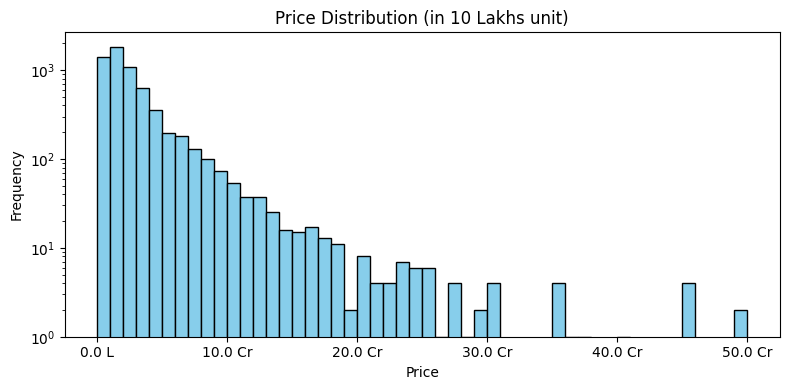


Price category distribution with fixed binning:
category
High         1599
Low          1567
Medium       1566
Very High    1524
Name: count, dtype: int64


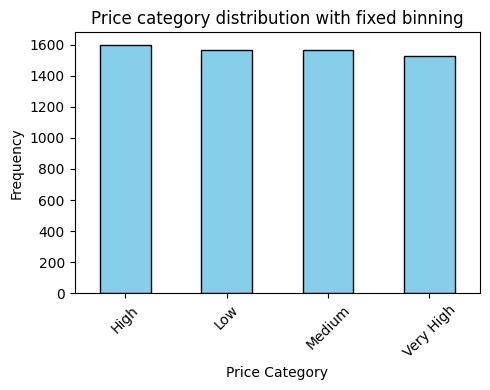


% of properties in each category:
category
High         25.559463
Low          25.047954
Medium       25.031969
Very High    24.360614
Name: count, dtype: float64


In [74]:
# Task 5: Target Variable Imbalance Detection

# Distribution of 'Price' in 10 bins

train['new_Price']=train['Price']/10**6  #10 lakh
test['new_Price']=test['Price']/10**6

min_Price=train['new_Price'].min()
max_Price=train['new_Price'].max()
bins=np.arange(np.floor(min_Price), np.ceil(max_Price) + 10, 10)

plt.figure(figsize=(8, 4))
plt.hist(train['new_Price'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Price Distribution (in 10 Lakhs unit)')
plt.xlabel('Price')
plt.ylabel('Frequency')

def formatter(x, pos):
    if(x>=10):
        return(f'{x/10:.1f} Cr')
    else:
        return(f'{x:.1f} L')

plt.gca().xaxis.set_major_formatter(FuncFormatter(formatter))
plt.yscale('log')
plt.ylim(1, plt.ylim()[1])
plt.tight_layout()
plt.show()

# fixed binning

bins=[0, 1.050000e+07, 1.920000e+07, 3.500000e+07, np.inf]
labels=['Low', 'Medium', 'High', 'Very High']

train['category']=pd.cut(train['Price'], bins=bins, labels=labels)
test['category']=pd.cut(test['Price'], bins=bins, labels=labels)

count=train['category'].value_counts()
print("\nPrice category distribution with fixed binning:")
print(count)

plt.figure(figsize=(5, 4))
count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Price category distribution with fixed binning')
plt.xlabel('Price Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# imbalance percent
properties_Total=len(train)
imbalanced_Cat=count/properties_Total*100
print("\n% of properties in each category:")
print(imbalanced_Cat)


**Task 6: Handling Imbalanced Data**

### Random Undersampling

`Benefits:`

- Faster training & less computational time with reduced data size.
- represent classes equally, prevent biasness

`Limitations:`

- removes some instances of majority class.
- May lead to overfitting in minority classes.
- Not suitable for very small minority classes.


### Random Oversampling

`Benefits:`

- All data retained, minority class in duplicated
- helps model in learning minority classes

`Limitations:`

- overfitting coz of duplicates
- more training and computational time
- Unsuitable for very small minority classes

In [75]:
# Task 6: Handling Imbalanced Data

# Random Undersampling
X=train.drop(columns=['category', 'new_Price'])
y=train['category']

under=RandomUnderSampler(random_state=42)
X_under, y_under=under.fit_resample(X, y)

print("After Random undersampling:")
print(y_under.value_counts())

# Random oversampling
over=RandomOverSampler(random_state=42)
X_over, y_over=over.fit_resample(X, y)

print("\nAfter Random oversampling:")
print(y_over.value_counts())


After Random undersampling:
category
Low          1524
Medium       1524
High         1524
Very High    1524
Name: count, dtype: int64

After Random oversampling:
category
Low          1599
Medium       1599
High         1599
Very High    1599
Name: count, dtype: int64


# **Building Decision Tree Model**



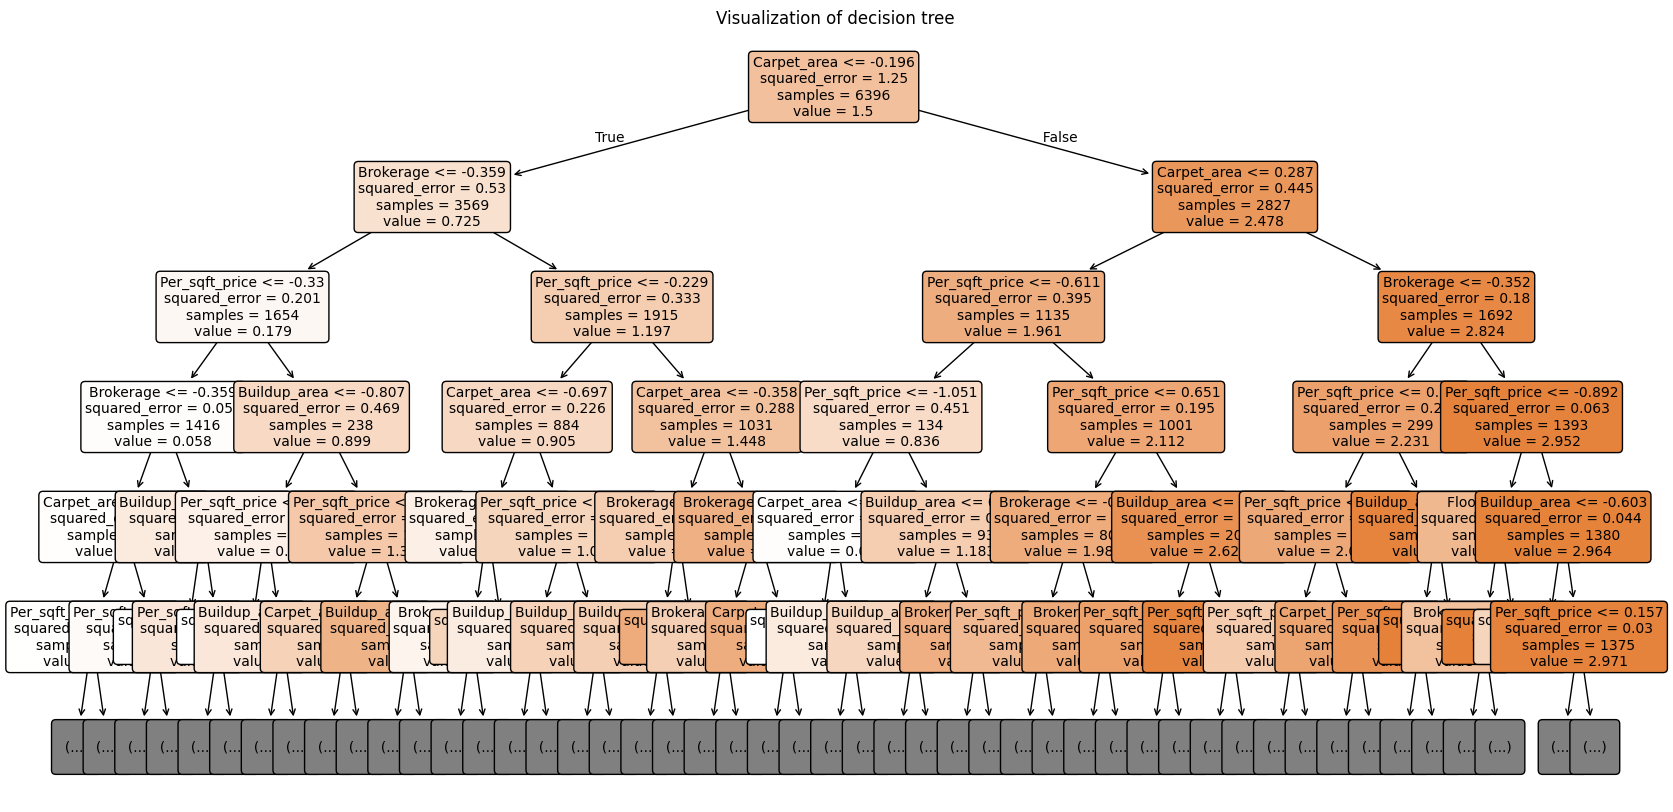

Tree Depth: 17
Number of Leaves: 277


In [76]:
# Task 1: Model Training

mapping={'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
train['binary_Price'] = train['category'].map(mapping)
test['binary_Price'] = test['category'].map(mapping)

X=train.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y=train['binary_Price']

# getting lower mse in Over sampling than Under sampling
over=RandomOverSampler(random_state=42)
X, y=over.fit_resample(X, y)

model=DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=5
)
plt.title("Visualization of decision tree")
plt.show()

# Explain the model structure
print(f"Tree Depth: {model.get_depth()}")
print(f"Number of Leaves: {model.get_n_leaves()}")


**# Task 2: Feature Importance and Hyperparameter Tuning**

`Carpet_area (0.691)` : Most important for Price as property size is a major part.

`Brokerage (0.152)` : Shows relevance and significant to Price.

`Per_sqft_price (0.111)` : price per sq. ft. generally affects the Price thats why it is somewhat important.

`Buildup_area (0.039)` : less important as carprt area is more related to Pricing.

`Floor & BHK` : Low impact, as floor level is less important compared to size.

`Parking, Bathrooms, Furnishing, Total_bedrooms` are least, not important at all.

Matches expectations

- Carpet_area is expected to be the most important, as the size of the property plays a major role in pricing.
- Brokerage is also highly important, as it's a major cost in property pricing.
- Per_sqft_price is important as the price per square foot is a direct affects the property price, which is expected.
- Buildup_area is usable are but not that much relevant than Carpet_area.
- Floor, BHK, Parking, and Bathrooms feels less important, which is consistent with expectations as they comes after size related features for price determination.
- Furnishing and Total_bedrooms does't matter at all.

Feature importance:
          Feature  Importance
2     Carpet_area    0.694796
5       Brokerage    0.151135
7  Per_sqft_price    0.110392
1    Buildup_area    0.039226
6           Floor    0.002263
8             BHK    0.000864
0      Furnishing    0.000521
3       Bathrooms    0.000319
4         Parking    0.000318
9  Total_bedrooms    0.000165


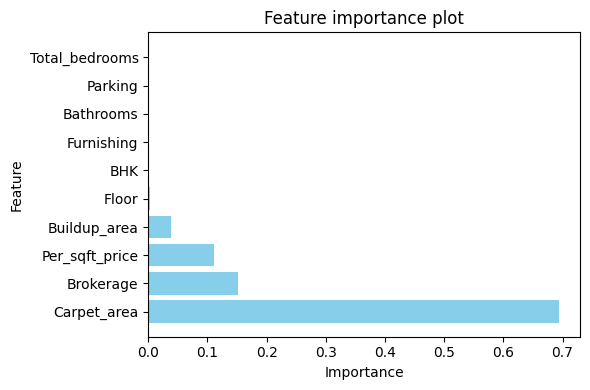

[I 2024-12-04 01:28:23,898] A new study created in memory with name: no-name-cb0946b4-fdcd-4046-835f-d67bbd6c1169
[I 2024-12-04 01:28:23,914] Trial 0 finished with value: 0.13831400970524088 and parameters: {'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.13831400970524088.
[I 2024-12-04 01:28:23,934] Trial 1 finished with value: 0.08080540929533583 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 1 with value: 0.08080540929533583.
[I 2024-12-04 01:28:23,970] Trial 2 finished with value: 0.04257462814243094 and parameters: {'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.04257462814243094.
[I 2024-12-04 01:28:23,989] Trial 3 finished with value: 0.15453597722280732 and parameters: {'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is

Best Hyperparameters:  {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}
Mean Squared Error (Tuned Model): 0.035210503472222224
Mean Squared Error (Default Model): 0.040625


In [77]:
# Task 2: Feature Importance and Hyperparameter Tuning

# PART A & B : FEATURE IMP.

feature_Imp = model.feature_importances_

df=pd.DataFrame({'Feature': X.columns,'Importance': feature_Imp})
df=df.sort_values(by='Importance', ascending=False)

print("Feature importance:")
print(df)

plt.figure(figsize=(6, 4))
plt.barh(df['Feature'], df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance plot')
plt.tight_layout()
plt.show()

# PART C : HYPERPARAMETER TUNING using OPTUNA

mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
train['binary_Price'] = train['category'].map(mapping)

X=train.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y=train['binary_Price']

over=RandomOverSampler(random_state=42)
X_resampled, y_resampled=over.fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    model=DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    model.fit(X_train, y_train)

    y_pred=model.predict(X_val)
    mse=mean_squared_error(y_val, y_pred)

    return(mse)

check=optuna.create_study(direction='minimize')
check.optimize(objective, n_trials=50)

best_Params = check.best_params
print("Best Hyperparameters: ", best_Params)

# Tuned model
mTuned=DecisionTreeRegressor(max_depth=best_Params['max_depth'], min_samples_split=best_Params['min_samples_split'], min_samples_leaf=best_Params['min_samples_leaf'], max_features=best_Params['max_features'], random_state=42)
mTuned.fit(X_train, y_train)
y_pred_tuned=mTuned.predict(X_val)
mse_tuned=mean_squared_error(y_val, y_pred_tuned)
print(f"Mean Squared Error (Tuned Model): {mse_tuned}")

# Default model
mDefault = DecisionTreeRegressor(random_state=42)
mDefault.fit(X_train, y_train)
y_pred_default = mDefault.predict(X_val)
mse_default = mean_squared_error(y_val, y_pred_default)
print(f"Mean Squared Error (Default Model): {mse_default}")


**Task 3: Pruning Decison Tree:**

Unpruned Tree :
- we are capturing all splits in data to minimize errors with more depth and leaf count.
- may result in overfitting
- they might show higher accuracy but may perform poorly on test data.

Pruned Tree :
- optimized version of the model with less depth and nodes.
- mainly focus on meaningful splits, reduces the complexity of tree.
- on sacrificing small accuracy we may get better test accuracy.
- easy to interpret with less depth

Also on manually trying pre-pruning with max_depth=11, I got the best mse value than the default model.

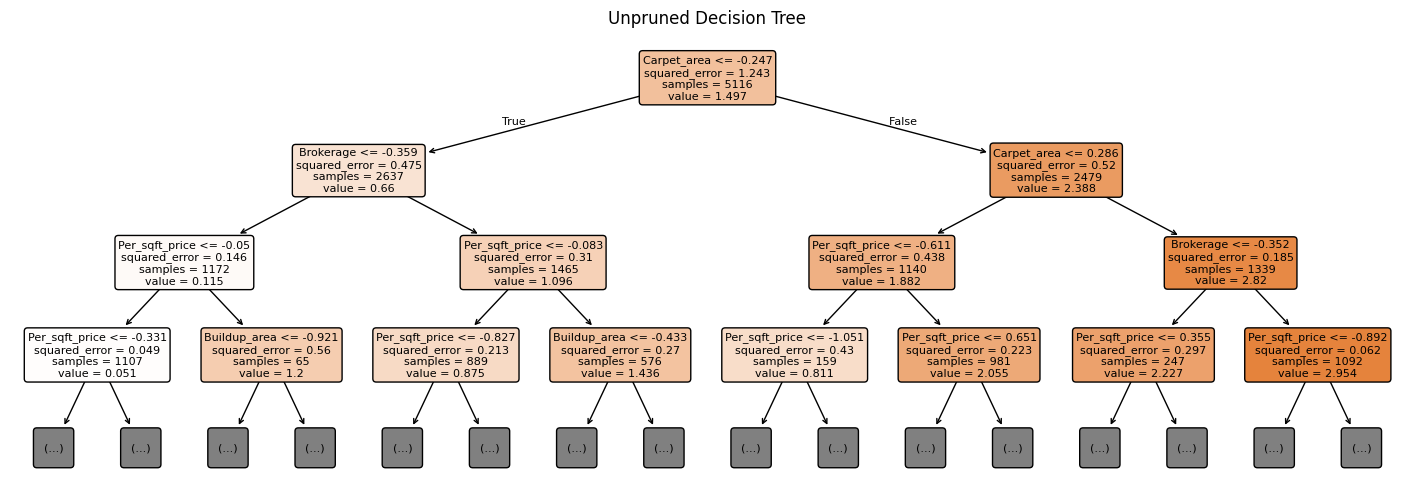

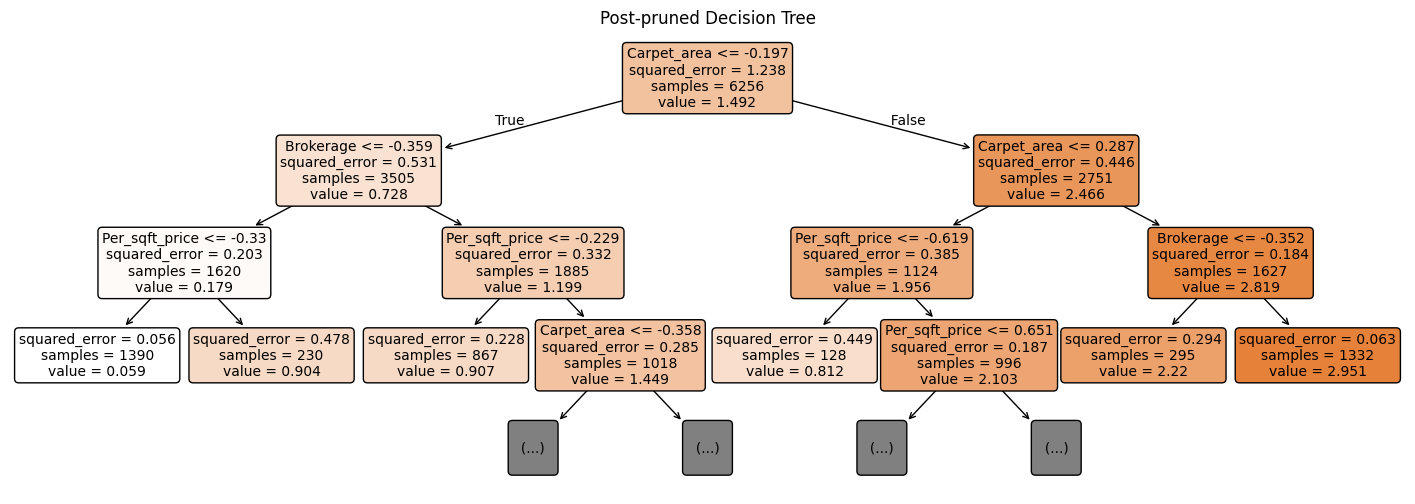

In [78]:
# Task 3: Pruning Decison Tree:

path=mDefault.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

best_alpha = ccp_alphas[-10]

post_mPruned=DecisionTreeRegressor(ccp_alpha=best_alpha, max_depth=12, min_samples_split=4, min_samples_leaf=7, max_features= None)
post_mPruned.fit(X, y)

# Visualising unpruned version
plt.figure(figsize=(18, 6))
plot_tree(mDefault, filled=True, feature_names=X.columns, fontsize=8, class_names=['Low', 'Medium', 'High', 'Very High'], rounded=True, max_depth=3)
plt.title("Unpruned Decision Tree")
plt.show()

# Visualising post-pruned version
plt.figure(figsize=(18, 6))
plot_tree(post_mPruned, filled=True, feature_names=X.columns, fontsize=10, class_names=['Low', 'Medium', 'High', 'Very High'], rounded=True, max_depth=3)
plt.title("Post-pruned Decision Tree")
plt.show()

**Task 4: Handling Overfitting** `[ PART A ]`

`post_mPruned` : Mean MSE: 0.1577 | Standard Deviation: 0.0107

*   have higher mse on train data but on test data it will not overfit as the model is simpler. will be better in undertsnading decision tree.

`mDefault` : Mean MSE: 0.0585 | Standard Deviation: 0.0102

* its showing less mse on train data but it might overfit on test data coz of higher depth and leaf structure.

`mTuned` : Mean MSE: 0.0544 | Standard Deviation: 0.0057

* lowest mse, smallest deviation. tuning might find a good balance in model fit.

will try mTuned and post_mPruned both on test data laters as they most unlikely to overfit.

`[ PART B ]`

**learning curve observations**

- Training MSE : starts at low value shows model fits the training data. we can also see that it stabilizes as set size increases shows model is working effectively without overfitting

- Validation MSE: starts high and decreases rapidly showing the improved model generalization. Also stabilies in the end

- getting best learning curves on Tuned model. In defualt the gap was too mcuh, in post pruned the gap is kess but there is over fitting and it's not stable.

`[ PART C ]`

With CV we can mainly try to mitigate overfitting, especially with decision tress because of depth & noise issues.

1.   By using k folds we can check if the model is generalizing well or not.
2.   helps in finding a balance b/w underfitting and overfitting by trying differnet prarams of decision trees.
3. we validated different model using CV helps use to observe pruned or unpruned versions.
4. helps in detecting overfitting.
5. we can get an idea if the current ensemble way is working or we need a different ensemble method. If the gap is large eveb after pruning, tuning it's better to swicth to some other ensemble.




Cross-Validation MSE Scores for Tuned model: [0.05717519 0.05540012 0.04856115 0.04617417 0.04465317]
Mean MSE: 0.0504
Standard Deviation of MSE: 0.0050



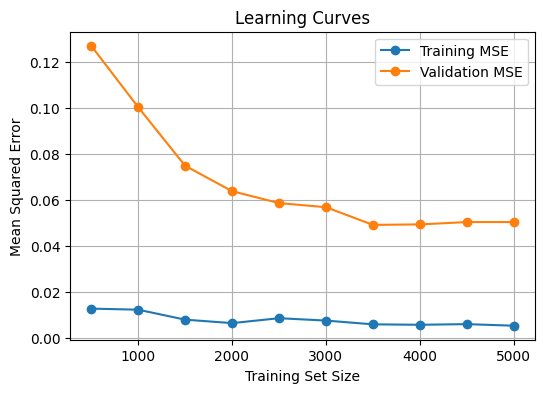

In [79]:
# Task 4: Handling Overfitting

# PART A : cross-validation

cv_Scores = cross_val_score(mTuned, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_Scores = -cv_Scores

print(f"Cross-Validation MSE Scores for Tuned model: {cv_mse_Scores}")
print(f"Mean MSE: {cv_mse_Scores.mean():.4f}")
print(f"Standard Deviation of MSE: {cv_mse_Scores.std():.4f}\n")

# PART B : Implement learning curves

train_Sizes, train_Scores, val_Scores=learning_curve(mTuned, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_MSE = -train_Scores.mean(axis=1)
val_MSE = -val_Scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_Sizes, train_MSE, label='Training MSE', marker='o')
plt.plot(train_Sizes, val_MSE, label='Validation MSE', marker='o')
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

# **Model Evaluation and Error Analysis**

In [80]:
# Task 1: Model Evaluation

# saving error stats for training data

y_pred_train = mTuned.predict(X_val)

mse_train = mean_squared_error(y_val, y_pred_train)
mae_train = mean_absolute_error(y_val, y_pred_train)
r2_train = r2_score(y_val, y_pred_train)


In [81]:
# Task 1: Model Evaluation

# Tuned model ( retraining mTuned on 100% train data )

mapping={'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
train['binary_Price']=train['category'].map(mapping)

X=train.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y=train['binary_Price']

over=RandomOverSampler(random_state=42)
X, y=over.fit_resample(X, y)

mTuned=DecisionTreeRegressor(max_depth=12, min_samples_split=4, min_samples_leaf=7, max_features= None) # from optuna
mTuned.fit(X, y)

# TEST DATA

test['binary_Price']=test['category'].map(mapping)

X_test=test.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y_test=test['binary_Price']

over=RandomOverSampler(random_state=42)
X_test, y_test=over.fit_resample(X_test, y_test)

# Tuned model on TEST data

y_pred_test = mTuned.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Metrics for Tuned Model on TEST DATA:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}\n")

# Tuned model on TRAIN data

print("Metrics for Tuned Model on TRAIN DATA:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")



Metrics for Tuned Model on TEST DATA:
Mean Squared Error (MSE): 0.0319
Mean Absolute Error (MAE): 0.0522
R-squared (R2): 0.9745

Metrics for Tuned Model on TRAIN DATA:
Mean Squared Error (MSE): 0.0352
Mean Absolute Error (MAE): 0.0374
R-squared (R2): 0.9724


`[ PART B ]`

MSE : test `0.0325` | train `0.0348`

- low mse indicates that the model prediction is quite close to the actual values.
- On test data there is very slight decrease in mse explains that model performs better & generalizes better to unseen data.
- model performs well on both data with slight decrease in error indicating model is not overfitting.

MAE : test `0.0524` | train `0.0515`
- same as MAE model is accuractely predicting with almost negligible increase of error on test data.

R2 : test `0.9740` | train `0.9728`
- Similarly here test and train values suggest that model explains approx 97%+ of the variance in training data as well on unseen data.
- Model feels robust, generalizes well and not overfitting.

Residuals summary stats:
Mean of residuals: 0.0009
Standard deviation of residuals: 0.1786
Minimum residual: -1.0000
Maximum residual: 1.0000


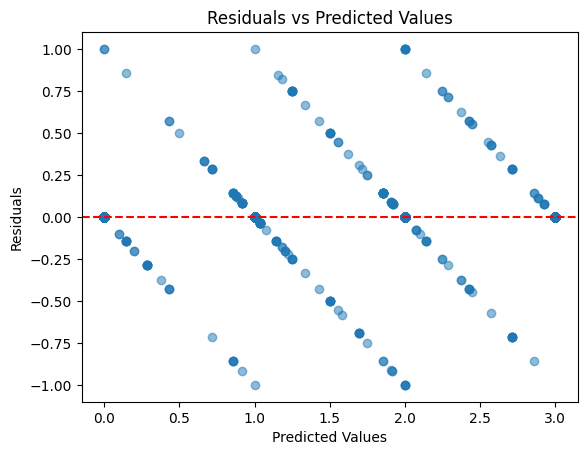

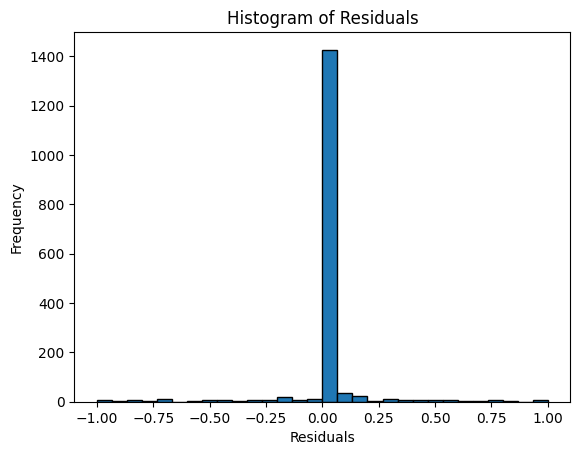

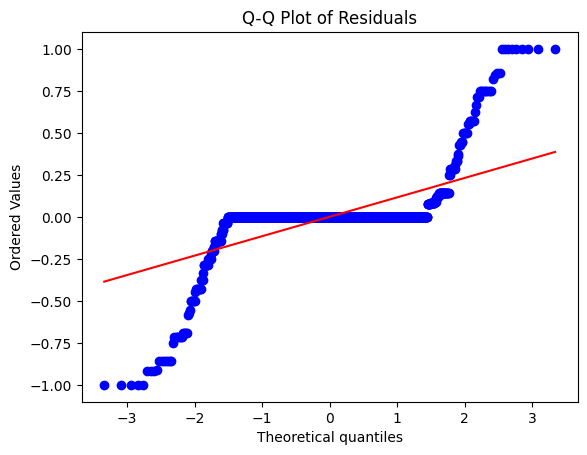

In [82]:
# Task 2 : Residual and Error Analysis

y_test_num=y_test.astype('float64')
residuals=y_test_num - y_pred_test

print(f"Residuals summary stats:")
print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation of residuals: {residuals.std():.4f}")
print(f"Minimum residual: {residuals.min():.4f}")
print(f"Maximum residual: {residuals.max():.4f}")

plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


- Mean of residuals `0.0008` : It's very close to zero shows that the model's predictions are quite accurate.
- Standard deviation `0.1803` : shows a higher value means model may fail to predict some specific points.
- Minimum residual `-1.0000` & Maximum residual `1.0000` : shows outlier data points are present.

Residuals vs Predicted Values shows  need for other ensemble models & feature engineering. model may perform poorly in case of low or high values.

Histogram's spike shows the presence of outliers and overfitting cases. but we have already verified it using CV.

QQplot shows the lack of feature callibration in model.

Yes, there are groups of data where the model consistently underperforms.

`Improvemnets` :

1.   We can apply Log transformation, make model more precise for all predicted values

2.   try more flexible ensemble methods like random forst, XGboost, etc

3.   feature engineering




Top 3 features: Index(['Per_sqft_price', 'Brokerage', 'Carpet_area'], dtype='object')
RMSE for the model using top 3 features: 0.1679



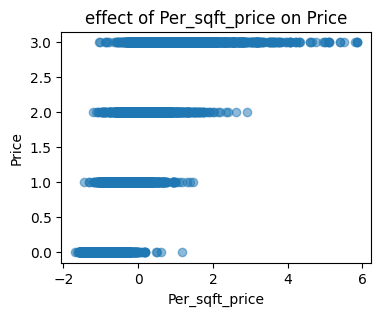

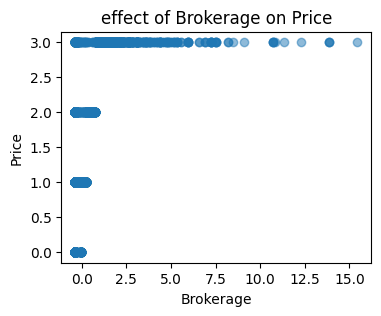

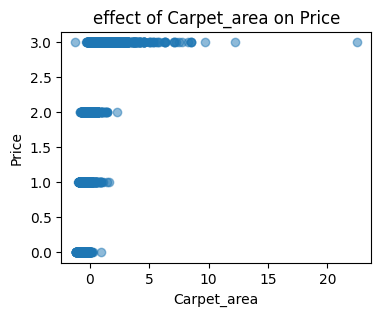

In [83]:
# Task 3 : Feature Importance based analysis

features=mTuned.feature_importances_
top3=np.argsort(features)[-3:]

top3_features=X.columns[top3]
print("Top 3 features:", top3_features)

X_top3=X[top3_features]

over=RandomOverSampler(random_state=42)
X_top3, y=over.fit_resample(X_top3, y)

mTop3=DecisionTreeRegressor(max_depth=12, min_samples_split=4, min_samples_leaf=7, max_features=None)
mTop3.fit(X_top3, y)

y_pred_top3=mTop3.predict(X_top3)

rmse_top3=np.sqrt(mean_squared_error(y, y_pred_top3))
print(f"RMSE for the model using top 3 features: {rmse_top3:.4f}\n")

# visualizing top 3features

plt.figure(figsize=(4, 3))
plt.scatter(X[top3_features[0]], y, alpha=0.5)
plt.title(f"effect of {top3_features[0]} on Price")
plt.xlabel(top3_features[0])
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(X[top3_features[1]], y, alpha=0.5)
plt.title(f"effect of {top3_features[1]} on Price")
plt.xlabel(top3_features[1])
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(X[top3_features[2]], y, alpha=0.5)
plt.title(f"effect of {top3_features[2]} on Price")
plt.xlabel(top3_features[2])
plt.ylabel('Price')
plt.show()


# **Bonus Challenge**

In [84]:
# Task 2:Ensemble Learning: Random Forest

mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
train['binary_Price'] = train['category'].map(mapping)
X=train.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y=train['binary_Price']

test['binary_Price'] = test['category'].map(mapping)
X_test = test.drop(columns=['Price', 'category', 'new_Price', 'binary_Price'])
y_test = test['binary_Price']

over=RandomOverSampler(random_state=42)
X, y=over.fit_resample(X, y)
X_test, y_test=over.fit_resample(X_test, y_test)

mTuned_rf=RandomForestRegressor(n_estimators=199, max_depth=18, min_samples_split=3, min_samples_leaf=1, max_features=None)
mTuned_rf.fit(X, y)

y_pred_test=mTuned_rf.predict(X_test)

mse_test_rf=mean_squared_error(y_test, y_pred_test)
mae_test_rf=mean_absolute_error(y_test, y_pred_test)
r2_test_rf=r2_score(y_test, y_pred_test)

print("Metrics for Tuned Random Forest Model on TEST DATA:")
print(f"Mean Squared Error (MSE): {mse_test_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test_rf:.4f}")
print(f"R-squared (R2): {r2_test_rf:.4f}\n")

print("Metrics for Tuned Decision tree on TEST DATA:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}\n")


Metrics for Tuned Random Forest Model on TEST DATA:
Mean Squared Error (MSE): 0.0157
Mean Absolute Error (MAE): 0.0459
R-squared (R2): 0.9874

Metrics for Tuned Decision tree on TEST DATA:
Mean Squared Error (MSE): 0.0319
Mean Absolute Error (MAE): 0.0522
R-squared (R2): 0.9745



`Random Forest beats the Decision Tree`
 - lower MSE and MAE shows Random forest has a lot better prediction accuracy.

` Trade-offs`

- Bias Variance Trade-off : Random forest reduces variance averaging from multiple trees using baggin. This helps in better generalization & less overfitting.

`Accuracy`

- RF has higher accuracy than normal decision tree because it is an ensemble of multiple trees & can capture complex patterns.

Decision trees are sensitive to noise & special cases. they might need pruning. RF is more robust and average out the prediction. Rndom forest is more reliable even in feature importance as it' shas multiple trees and splits.

Decision tree is faster to train as it's just a single tree. Random forest is more computational as it as multiple trees and takes more time to train.